<a href="https://colab.research.google.com/github/WilliamGaggiotti/MELI/blob/main/PT_MELI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import pandas as pd
import numpy as np
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import tensorflow as tf
from IPython.display import display, HTML
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
#Constanst
PANDAS_TYPE = pd.core.frame.DataFrame

In [3]:
############################
##       Utils            ##
############################

def gen_dataset(category_id: str) -> PANDAS_TYPE:
  jsonSTR = {}
  for i in range(21):
    response_api = requests.get(f"https://api.mercadolibre.com/sites/MLA/search?category={category_id}&offset={i*50}")
    for j in range(len(response_api.json()['results'])):
      product = response_api.json()['results'][j]
      seller_r = product["seller"]["seller_reputation"]
      #Buscamos el modelos y la marca del producto
      for atr in product['attributes']:
        if atr["name"] == "Marca":
          marca = atr["value_name"]
        elif atr["name"] == "Modelo":
          modelo = atr["value_name"]

      jsonSTR["Index{}".format(i*50+j)] = {
              "Price": product["price"],
              "Discount": int(product["original_price"]) - int(product["price"]) if product["original_price"] else 0,
              "Sold_quantity": product["sold_quantity"],
              "Available_quantity": product["available_quantity"],
              "Condition": product["condition"],
              "Marca": marca,
              "Modelo":modelo,
              "Seller_level": seller_r["level_id"],
              "Seller_transactions_canceled": seller_r["transactions"]["canceled"],
              "Seller_transactions_completed": seller_r["transactions"]["completed"],
              "Seller_ratings_negative": seller_r["transactions"]["ratings"]["negative"],
              "Seller_ratings_positive": seller_r["transactions"]["ratings"]["positive"],
              "Free_shipping": product["shipping"]["free_shipping"],
          } 
  df = pd.DataFrame.from_dict(jsonSTR, orient ='index')
  #estandarizamos a lower str
  for col in ["Marca","Modelo","Seller_level"]:
    df[col] = df[col].str.lower()
    
  return df


def discount(category_id: str) -> None:
  #Display de nombre de categoria
  response_api = requests.get(f"https://api.mercadolibre.com/categories/{category_id}")
  print('#############################')
  print('#############################')
  print(f"### {response_api.json()['name']}")
  print('#############################')
  print('#############################')

  #Display de descuentos
  response_api = requests.get(f"https://api.mercadolibre.com/sites/MLA/search?category={category_id}")
  discounts = [item['values'] for item in response_api.json()['available_filters'] if item['id'] == 'discount']

  if not discounts:
    return 'No hay descuentos para esta categoria'

  discounts = discounts[0]
  average = 0
  print('La cantidad de productos en los distintos descuentos son: \n')
  for i in range(len(discounts)):
    discount_rate = int(discounts[i]['id'].split("-")[0]) # uper_cap
    lower_cap = int(discounts[i-1]['id'].split("-")[0]) if i!=0 else 0
    total = discounts[i]['results'] - discounts[i+1]['results'] if i < len(discounts)-1 else discounts[i]['results']
    print(f"  {discount_rate}%: {total}")
    average += total * ((discount_rate + lower_cap) / 2)
    
  average /= discounts[0]['results'] 

  #Display de total de productos en descuento
  print(f"\nEn totas hay {discounts[0]['results']} para esta categoria. Lo que representa el {'{:.2f}'.format((discounts[0]['results']/response_api.json()['paging']['total'])*100)}% de productos.")
  print(f"El descuento promedio, asumiendo que cada descuento representa la cota superior de descuento, y tomando un punto medio como referencia")
  print(f"(para 5% seria de 2.5%), y calculando un promedio total en base a eso, el resultado es: {'{:.2f}'.format(average)}%. \n")

def top_x_product(df: PANDAS_TYPE, cant_prod: int) -> None:
  print('#################################')
  print(f"## Los {cant_prod} productos mas vendidos")
  print('################################# \n')
  top_x_df = df.sort_values(by=['Sold_quantity'], ascending=False)[0:cant_prod]
  display(top_x_df)

  #Iteramos para obtener metricas 
  sl_average = 0 #Seller_level average
  srp_sl_average = 0 #Seller_rating_positive average
  ptc_average = 0 #Promedio de transacciones completadas
  p_new_average = 0 #Promedio de productos nuevos
  fs_average = 0 # Promedio de productos con envio gratis
  for _, prod in top_x_df.iterrows():
    sl_average += int(prod['Seller_level'][0])
    srp_sl_average += prod['Seller_ratings_positive']
    ptc_average += prod['Seller_transactions_completed'] / (prod['Seller_transactions_completed'] + prod['Seller_transactions_canceled'])
    p_new_average += 1 if prod['Condition'] == 'new' else 0
    fs_average += 1 if prod['Free_shipping'] else 0

  sl_average /= cant_prod
  srp_sl_average /= cant_prod
  ptc_average /= cant_prod
  p_new_average /= cant_prod
  fs_average /= cant_prod

  print(f"  Reputacion promedio de los vendedores: {sl_average}")
  print(f"  Calificación promedio de los vendedores: {'{:.2f}'.format(srp_sl_average)}")
  print(f"  El porcentaje  de las transacciones completadas por los vendedores: {'{:.2f}'.format(ptc_average * 100)}%")
  print(f"  El porcentaje  de productos nuevos: {p_new_average *100}%")
  print(f"  El porcentaje  de productos con envío gratis: {fs_average * 100}% \n")

def other_metrics(df: PANDAS_TYPE) -> None:
  print('#################################')
  print(f"## Otras metricas")
  print('################################# \n')
  display(df.describe())


def conver_to_numeric(df, string_colums) ->PANDAS_TYPE:
  new_df = df
  for col in string_colums:
    le = preprocessing.LabelEncoder()
    le.fit(new_df [col])
    new_df [col] = le.transform(new_df [col])

  return new_df

def corr_matrix(df:PANDAS_TYPE) -> None:
  corr_df = df.corr(method='pearson')
  plt.figure(figsize=(10, 10))
  sns.heatmap(corr_df, annot=True)
  plt.show()


def nor_std(x: PANDAS_TYPE) -> PANDAS_TYPE:
  x_stats  =x.describe().transpose()

  return (x - x_stats['mean']) / x_stats['std']


##Show Metrics

#############################
#############################
### Televisores
#############################
#############################
La cantidad de productos en los distintos descuentos son: 

  5%: 29
  10%: 57
  15%: 34
  20%: 19
  25%: 5
  30%: 10

En totas hay 154 para esta categoria. Lo que representa el 1.42% de productos.
El descuento promedio, asumiendo que cada descuento representa la cota superior de descuento, y tomando un punto medio como referencia
(para 5% seria de 2.5%), y calculando un promedio total en base a eso, el resultado es: 10.68%. 

#################################
## Los 10 productos mas vendidos
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Condition,Marca,Modelo,Seller_level,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive,Free_shipping
Index4,66499.0,0,9443,444,new,samsung,un43t5300ag,5_green,41709,768911,0.05,0.93,True
Index1,53999.0,2000,3131,747,new,philips,43pfd6825,5_green,41709,768911,0.05,0.93,True
Index0,31499.0,0,1826,276,new,noblex,dk32x5000,5_green,1315,25867,0.03,0.94,True
Index7,26799.0,3200,1634,28,new,philips,24phd5565,5_green,41709,768911,0.05,0.93,True
Index3,36699.0,3300,956,411,new,tcl,l32s60a,5_green,41709,768911,0.05,0.93,True
Index6,46999.0,3000,805,1005,new,tcl,l40s65a,5_green,41709,768911,0.05,0.93,True
Index12,48999.0,0,708,137,new,tcl,l42s6500,5_green,2161,37051,0.06,0.87,True
Index14,43999.0,6000,694,588,new,telefunken,tk4319fk5,5_green,41709,768911,0.05,0.93,True
Index29,33999.0,0,676,97,new,philco,pld32hs9a1,5_green,2161,37051,0.06,0.87,True
Index51,78999.0,7300,500,50,new,noblex,dk50x6500,5_green,2911,44889,0.04,0.91,True


  Reputacion promedio de los vendedores: 5.0
  Calificación promedio de los vendedores: 0.92
  El porcentaje  de las transacciones completadas por los vendedores: 94.72%
  El porcentaje  de productos nuevos: 100.0%
  El porcentaje  de productos con envío gratis: 100.0% 

Matrix de correlacion de las variables no nominales


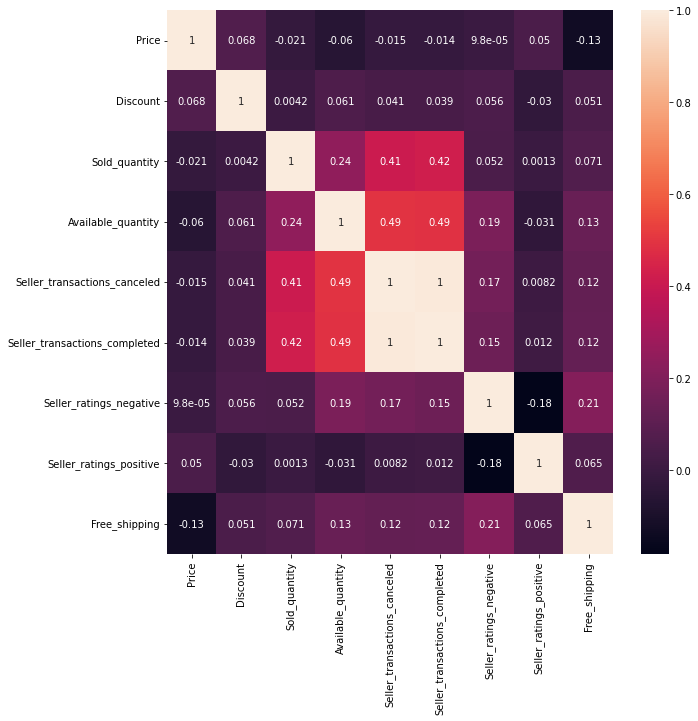

#################################
## Otras metricas
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive
count,1.049000e+03,1049.000000,1049.000000,1049.000000,1049.000000,1049.000000,1049.000000,1049.000000
mean,9.453722e+04,975.631077,37.507150,46.481411,2641.655863,42594.383222,0.030086,0.926311
std,2.162664e+05,6812.867579,324.492561,122.523677,5501.366544,98897.207785,0.028926,0.124570
min,9.900000e+01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.789900e+04,0.000000,0.000000,1.000000,150.000000,1986.000000,0.010000,0.920000
50%,5.990000e+04,0.000000,3.000000,1.000000,1315.000000,20390.000000,0.030000,0.950000
75%,9.799900e+04,0.000000,5.000000,50.000000,2819.000000,41549.000000,0.040000,0.970000
max,5.990000e+06,170000.000000,9443.000000,1713.000000,41709.000000,768911.000000,0.520000,1.000000


#############################
#############################
### Celulares y Smartphones
#############################
#############################
La cantidad de productos en los distintos descuentos son: 

  5%: 102
  10%: 92
  15%: 14
  20%: 12
  30%: 1

En totas hay 221 para esta categoria. Lo que representa el 0.43% de productos.
El descuento promedio, asumiendo que cada descuento representa la cota superior de descuento, y tomando un punto medio como referencia
(para 5% seria de 2.5%), y calculando un promedio total en base a eso, el resultado es: 6.13%. 

#################################
## Los 10 productos mas vendidos
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Condition,Marca,Modelo,Seller_level,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive,Free_shipping
Index3,86999.0,16000,11128,752,new,samsung,s20 fe,5_green,41709,768911,0.05,0.93,True
Index2,61999.0,10000,7653,69,new,samsung,a52,5_green,41709,768911,0.05,0.93,True
Index0,52999.0,0,3313,294,new,motorola,g60s,5_green,41709,768911,0.05,0.93,True
Index1,69999.0,0,3062,873,new,motorola,20 lite,5_green,41709,768911,0.05,0.93,True
Index20,4939.0,0,2958,148,new,sansei,s191,5_green,17200,295418,0.04,0.94,True
Index22,20399.0,2600,2302,68,new,zte,a5 plus,5_green,2819,33867,0.03,0.95,True
Index54,14595.0,0,1441,18,new,alcatel,1x,5_green,430,5815,0.04,0.95,True
Index6,44999.0,0,1434,40,new,samsung,m12 (5000 mah),5_green,6313,109144,0.06,0.92,True
Index7,119999.0,0,1379,708,new,motorola,20 pro,5_green,41709,768911,0.05,0.93,True
Index11,31199.0,3800,1331,184,new,xiaomi,9a,5_green,10877,220252,0.02,0.96,True


  Reputacion promedio de los vendedores: 5.0
  Calificación promedio de los vendedores: 0.94
  El porcentaje  de las transacciones completadas por los vendedores: 94.40%
  El porcentaje  de productos nuevos: 100.0%
  El porcentaje  de productos con envío gratis: 100.0% 

Matrix de correlacion de las variables no nominales


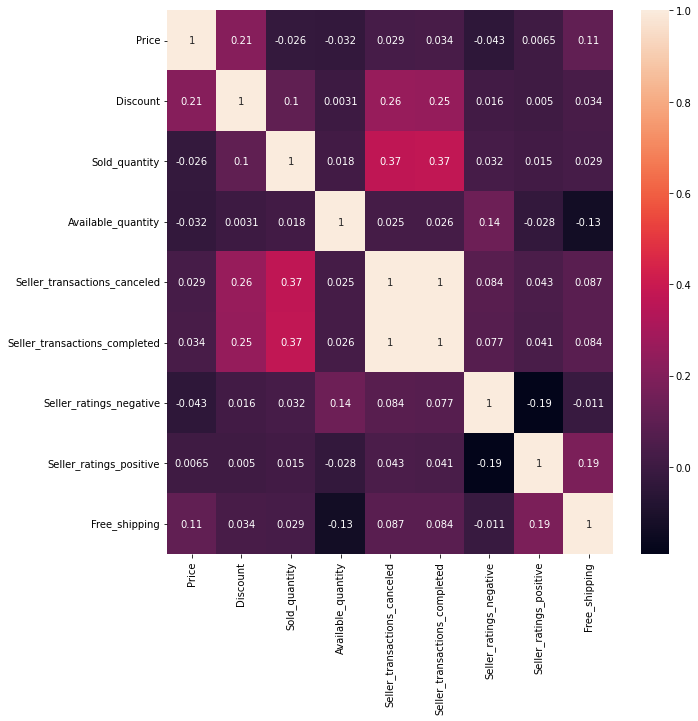

#################################
## Otras metricas
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive
count,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000
mean,74117.972167,904.640460,69.450623,93.966443,3858.745925,66044.956855,0.033279,0.919511
std,79717.920349,5697.017638,472.123101,1551.288993,8815.759486,162109.985133,0.046974,0.162715
min,100.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,20714.990000,0.000000,2.000000,1.000000,138.000000,1348.000000,0.020000,0.930000
50%,49999.000000,0.000000,5.000000,1.000000,852.000000,10818.000000,0.030000,0.950000
75%,89999.000000,0.000000,21.500000,21.500000,2243.000000,34295.000000,0.040000,0.970000
max,507503.000000,117600.000000,11128.000000,50000.000000,41709.000000,768911.000000,1.000000,1.000000


#############################
#############################
### PC de Escritorio
#############################
#############################
La cantidad de productos en los distintos descuentos son: 

  5%: 445
  10%: 38
  15%: 23
  20%: 126
  25%: 15
  30%: 16

En totas hay 663 para esta categoria. Lo que representa el 3.11% de productos.
El descuento promedio, asumiendo que cada descuento representa la cota superior de descuento, y tomando un punto medio como referencia
(para 5% seria de 2.5%), y calculando un promedio total en base a eso, el resultado es: 7.04%. 

#################################
## Los 10 productos mas vendidos
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Condition,Marca,Modelo,Seller_level,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive,Free_shipping
Index764,66499.05,3500,500,250,new,sentey,amd a8 9600,5_green,2758,43127,0.02,0.95,True
Index514,64999.00,0,500,250,new,intel,i5-8400,5_green,2758,43127,0.02,0.95,True
Index26,56999.00,0,500,150,new,intel,celeron,5_green,2758,43127,0.02,0.95,True
Index70,37049.05,1950,500,250,new,intel,celeron,5_green,2758,43127,0.02,0.95,True
Index805,102599.05,5400,500,500,new,amd,ryzen 5 3400g,5_green,2758,43127,0.02,0.95,True
Index168,87399.05,4600,500,250,new,amd,athlon,5_green,2758,43127,0.02,0.95,True
Index21,69599.00,10503,500,5000,new,intel,intel,5_green,428,4914,0.02,0.97,True
Index902,47499.05,2500,500,100,new,intel,g4900,5_green,2758,43127,0.02,0.95,True
Index256,56999.05,3000,500,500,new,amd,a6-9500,5_green,2758,43127,0.02,0.95,True
Index1018,44649.05,2350,500,200,new,amd,gigabyte e2500,5_green,2758,43127,0.02,0.95,True


  Reputacion promedio de los vendedores: 5.0
  Calificación promedio de los vendedores: 0.95
  El porcentaje  de las transacciones completadas por los vendedores: 93.79%
  El porcentaje  de productos nuevos: 100.0%
  El porcentaje  de productos con envío gratis: 100.0% 

Matrix de correlacion de las variables no nominales


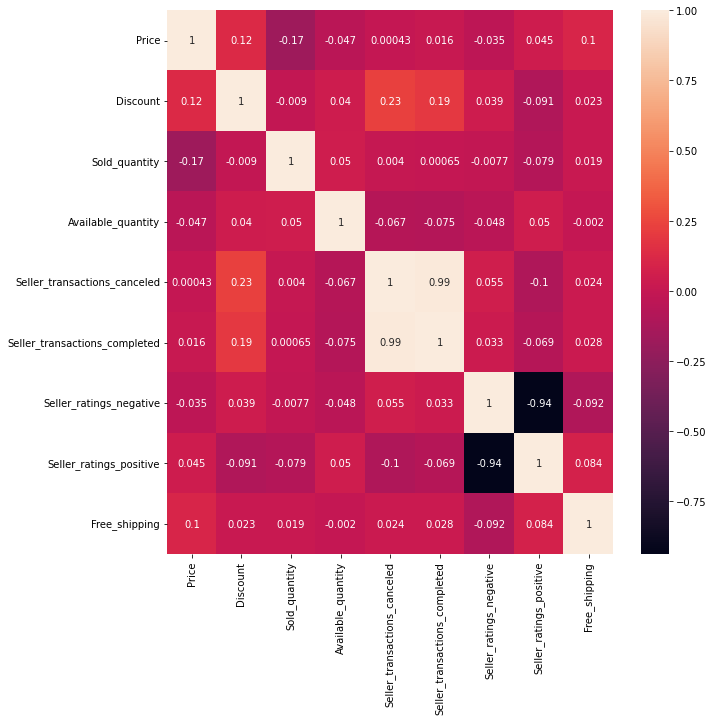

#################################
## Otras metricas
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive
count,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,92495.995943,1834.583810,34.642857,661.668571,2064.427619,35503.486667,0.025276,0.959010
std,59680.529500,6946.788603,85.451289,4458.321205,3781.723298,61017.869768,0.031839,0.034144
min,99.000000,0.000000,0.000000,1.000000,0.000000,5.000000,0.000000,0.240000
25%,52998.000000,0.000000,2.000000,1.000000,132.000000,2165.000000,0.010000,0.950000
50%,78332.275000,0.000000,5.000000,1.000000,502.000000,9180.000000,0.020000,0.970000
75%,117711.250000,0.000000,25.000000,1.000000,2758.000000,43127.000000,0.030000,0.980000
max,476999.000000,94500.000000,500.000000,50000.000000,24075.000000,349432.000000,0.760000,1.000000


#############################
#############################
### Periféricos de PC
#############################
#############################
La cantidad de productos en los distintos descuentos son: 

  5%: 1550
  10%: 212
  15%: 90
  20%: 258
  25%: 165
  30%: 256

En totas hay 2531 para esta categoria. Lo que representa el 3.45% de productos.
El descuento promedio, asumiendo que cada descuento representa la cota superior de descuento, y tomando un punto medio como referencia
(para 5% seria de 2.5%), y calculando un promedio total en base a eso, el resultado es: 8.64%. 

#################################
## Los 10 productos mas vendidos
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Condition,Marca,Modelo,Seller_level,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive,Free_shipping
Index2,1000.00,0,6508,108,new,logitech,m170,5_green,6027,162074,0.02,0.97,False
Index552,1424.05,75,5000,250,new,ztecno,zt-desk,5_green,1453,27563,0.00,1.00,False
Index477,1199.00,3801,5000,250,new,libercam,keykr-500,5_green,49612,783691,0.05,0.93,False
Index864,2264.00,0,5000,250,new,logitech,mk235,5_green,6027,162074,0.02,0.97,False
Index809,2277.15,120,5000,100,new,sinovision,sn-u3,5_green,5094,91489,0.03,0.96,False
Index259,2906.00,0,5000,200,new,sinovision,sn-u3,5_green,5094,91489,0.03,0.96,False
Index716,1690.00,0,5000,150,new,xinua,m3,5_green,7539,143942,0.01,0.97,False
Index1020,798.00,0,5000,50,new,bkt,pad mouse con gel / espuma,5_green,2042,19650,0.03,0.95,False
Index47,4800.00,0,4468,12,new,logitech,lightspeed,5_green,6027,162074,0.02,0.97,True
Index0,6620.00,0,3430,22,new,redragon,k552,5_green,10423,170275,0.02,0.96,True


  Reputacion promedio de los vendedores: 5.0
  Calificación promedio de los vendedores: 0.96
  El porcentaje  de las transacciones completadas por los vendedores: 94.76%
  El porcentaje  de productos nuevos: 100.0%
  El porcentaje  de productos con envío gratis: 20.0% 

Matrix de correlacion de las variables no nominales


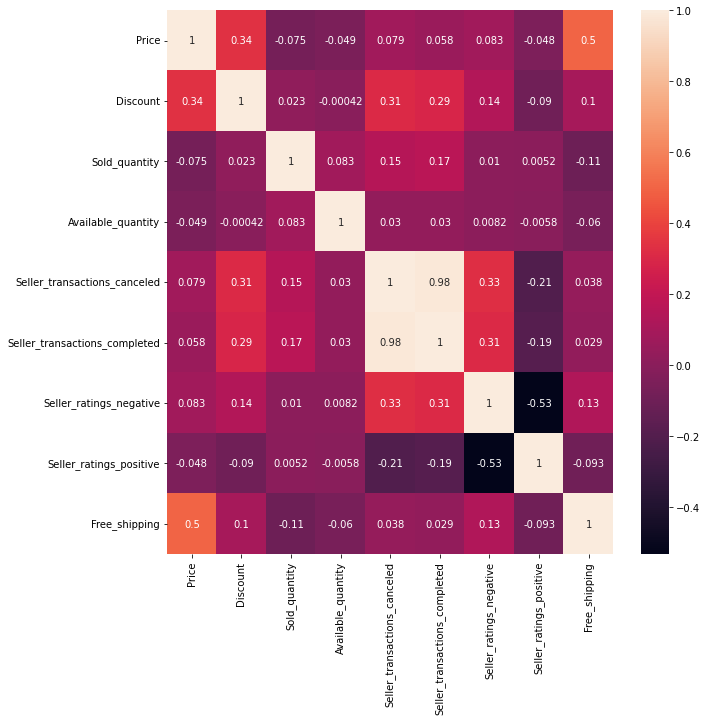

#################################
## Otras metricas
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive
count,1049.00000,1049.000000,1049.000000,1049.000000,1049.000000,1049.000000,1049.000000,1049.000000
mean,6825.14285,190.856053,174.118208,47.142040,4576.471878,75918.227836,0.021249,0.962383
std,10808.59579,1252.625291,548.821271,236.242795,7096.571604,113207.263722,0.017503,0.037499
min,189.05000,0.000000,0.000000,1.000000,0.000000,9.000000,0.000000,0.000000
25%,1599.00000,0.000000,5.000000,1.000000,504.000000,8273.000000,0.010000,0.950000
50%,3378.00000,0.000000,26.000000,6.000000,1543.000000,32423.000000,0.020000,0.970000
75%,7989.00000,0.000000,127.000000,38.000000,6313.000000,119167.000000,0.030000,0.980000
max,185509.00000,27200.000000,6508.000000,5000.000000,49612.000000,783691.000000,0.210000,1.000000


#############################
#############################
### Tablets y Accesorios
#############################
#############################
La cantidad de productos en los distintos descuentos son: 

  5%: 445
  10%: 101
  15%: 35
  20%: 74
  25%: 21
  30%: 75

En totas hay 751 para esta categoria. Lo que representa el 1.57% de productos.
El descuento promedio, asumiendo que cada descuento representa la cota superior de descuento, y tomando un punto medio como referencia
(para 5% seria de 2.5%), y calculando un promedio total en base a eso, el resultado es: 8.17%. 

#################################
## Los 10 productos mas vendidos
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Condition,Marca,Modelo,Seller_level,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive,Free_shipping
Index0,23687.44,18612,1008,11,new,gadnic,taurus phone,5_green,29739,487969,0.03,0.95,True
Index3,24499.00,13950,883,688,new,gadnic,fenix phone,5_green,29739,487969,0.03,0.95,True
Index16,29899.00,0,809,10,new,samsung,tab a7 lite,5_green,14662,221761,0.04,0.94,True
Index2,29259.00,0,572,145,new,samsung,tab a7 lite,5_green,10877,220252,0.02,0.96,True
Index563,22000.00,0,500,1,new,kindle,paperwhite 10 gen,5_green,1679,39402,0.06,0.90,True
Index574,29299.00,0,500,1,new,gadnic,fenix phone,5_green,29739,487969,0.03,0.95,True
Index132,1323.00,0,500,250,new,norcel,origami,5_green,3364,44484,0.02,0.96,False
Index579,2699.10,300,500,250,new,usams,lapiz blanco,5_green,3364,44484,0.02,0.96,False
Index128,1325.00,0,500,1,new,compatible,n1002g 10.1,5_green,713,11632,0.01,0.98,False
Index114,16990.00,1209,500,50,new,t-go,eutb-758,5_green,3870,69326,0.02,0.96,True


  Reputacion promedio de los vendedores: 5.0
  Calificación promedio de los vendedores: 0.95
  El porcentaje  de las transacciones completadas por los vendedores: 94.26%
  El porcentaje  de productos nuevos: 100.0%
  El porcentaje  de productos con envío gratis: 70.0% 

Matrix de correlacion de las variables no nominales


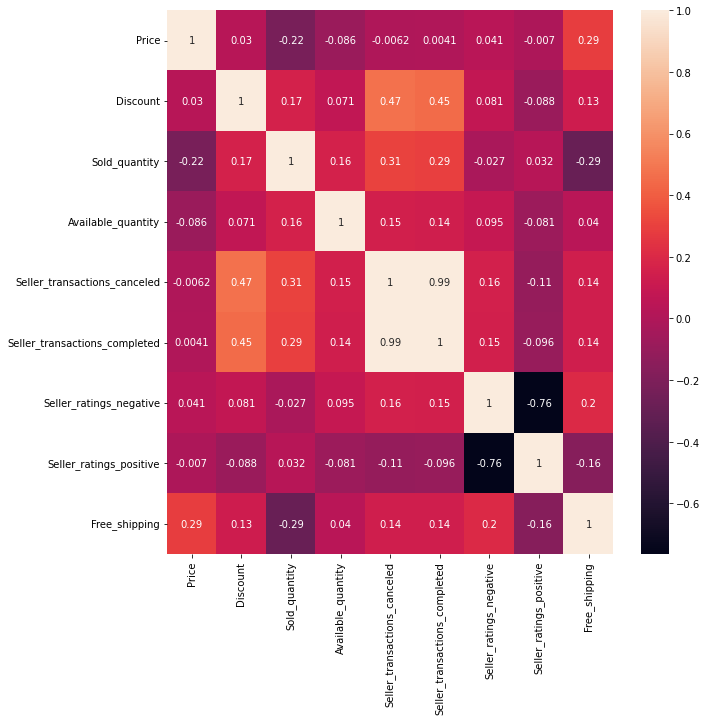

#################################
## Otras metricas
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive
count,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,37336.415448,766.508571,75.980952,58.789524,3548.508571,58220.260952,0.025305,0.954629
std,58122.883209,3399.000418,141.869136,154.006557,7760.774573,134709.014761,0.032199,0.055288
min,120.000000,0.000000,0.000000,1.000000,0.000000,7.000000,0.000000,0.000000
25%,7700.000000,0.000000,1.000000,1.000000,213.000000,2937.750000,0.010000,0.940000
50%,18494.500000,0.000000,5.000000,1.000000,742.000000,11548.000000,0.020000,0.960000
75%,34999.000000,0.000000,88.750000,10.750000,3364.000000,45745.000000,0.040000,0.980000
max,466299.000000,44700.000000,1008.000000,999.000000,49612.000000,783691.000000,0.710000,1.000000


#############################
#############################
### Almacenamiento
#############################
#############################
La cantidad de productos en los distintos descuentos son: 

  5%: 349
  10%: 33
  15%: 1
  20%: 30

En totas hay 413 para esta categoria. Lo que representa el 1.51% de productos.
El descuento promedio, asumiendo que cada descuento representa la cota superior de descuento, y tomando un punto medio como referencia
(para 5% seria de 2.5%), y calculando un promedio total en base a eso, el resultado es: 4.01%. 

#################################
## Los 10 productos mas vendidos
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Condition,Marca,Modelo,Seller_level,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive,Free_shipping
Index9,599.00,0,16098,585,new,multilaser,pd588,5_green,531,9970,0.02,0.96,False
Index0,8889.00,0,10859,38,new,kingston,sa400s37/480g,5_green,6483,135355,0.03,0.95,True
Index46,750.00,0,10085,92,new,verbatim,pinstripe,5_green,226,5262,0.02,0.96,False
Index15,11099.00,0,6565,39,new,seagate,stea2000400,5_green,6483,135355,0.03,0.95,True
Index5,699.00,0,5658,50,new,sandisk,blade,5_green,3607,51954,0.04,0.93,False
Index1041,10797.72,0,5000,1,new,seagate,stea2000400,5_green,6483,135360,0.03,0.95,True
Index668,6429.00,0,5000,250,new,western digital,wd10ezex,5_green,7079,116606,0.02,0.96,True
Index276,10199.00,0,5000,50,new,western digital,wdbu6y0020bbk,5_green,7238,116876,0.04,0.94,True
Index524,820.00,0,5000,1,new,caddy,"9,5mm sata a sata",5_green,1816,29796,0.01,0.98,False
Index362,1150.00,0,5000,1,new,todomicro,usb3.0-sata,5_green,6454,99444,0.02,0.96,False


  Reputacion promedio de los vendedores: 5.0
  Calificación promedio de los vendedores: 0.95
  El porcentaje  de las transacciones completadas por los vendedores: 94.72%
  El porcentaje  de productos nuevos: 100.0%
  El porcentaje  de productos con envío gratis: 50.0% 

Matrix de correlacion de las variables no nominales


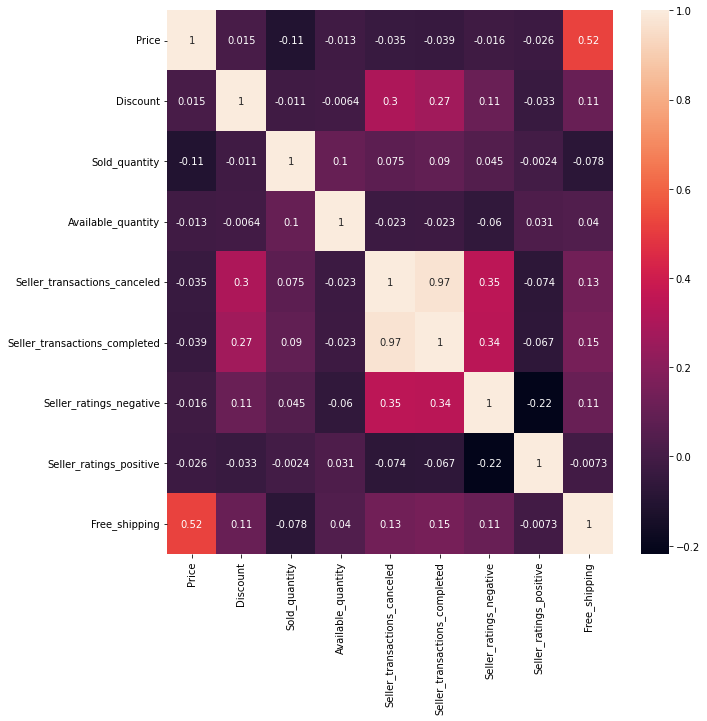

#################################
## Otras metricas
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive
count,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,10058.844276,50.174286,262.655238,284.647619,2567.843810,44278.146667,0.019933,0.962057
std,14232.758501,377.278670,895.937860,3112.784762,3394.052805,55129.155783,0.017304,0.070280
min,102.000000,0.000000,0.000000,1.000000,0.000000,10.000000,0.000000,0.000000
25%,1622.787500,0.000000,8.250000,1.000000,302.000000,5516.000000,0.010000,0.960000
50%,5149.000000,0.000000,50.000000,1.000000,1006.500000,18682.000000,0.020000,0.970000
75%,11970.000000,0.000000,250.000000,50.000000,3903.000000,64888.000000,0.030000,0.980000
max,142538.000000,6800.000000,16098.000000,50000.000000,24075.000000,349432.000000,0.190000,1.000000


#############################
#############################
### Componentes de PC
#############################
#############################
La cantidad de productos en los distintos descuentos son: 

  5%: 1300
  10%: 54
  15%: 38
  20%: 216
  25%: 18
  30%: 36

En totas hay 1662 para esta categoria. Lo que representa el 1.88% de productos.
El descuento promedio, asumiendo que cada descuento representa la cota superior de descuento, y tomando un punto medio como referencia
(para 5% seria de 2.5%), y calculando un promedio total en base a eso, el resultado es: 5.60%. 

#################################
## Los 10 productos mas vendidos
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Condition,Marca,Modelo,Seller_level,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive,Free_shipping
Index4,8889.00,0,10859,38,new,kingston,sa400s37/480g,5_green,6483,135360,0.03,0.95,True
Index49,11099.00,0,6565,39,new,seagate,stea2000400,5_green,6483,135360,0.03,0.95,True
Index169,1290.00,0,5000,500,new,arctic,mx-4 4gr.,5_green,1184,35645,0.00,0.99,False
Index451,1113.53,0,5000,250,new,arctic,mx4 4 gramos,5_green,1940,40341,0.01,0.97,False
Index979,1434.99,76,5000,150,new,poken,12038ac,5_green,593,10552,0.02,0.97,False
Index219,1527.40,655,5000,200,new,vt-fan,ct 4 a,5_green,3514,86739,0.02,0.97,False
Index456,1314.75,439,5000,100,new,vt-fan,ct 4 b,5_green,3514,86739,0.02,0.97,False
Index910,10199.00,0,5000,50,new,western digital,wdbu6y0020bbk,5_green,7238,116876,0.04,0.94,True
Index329,1587.00,0,5000,50,new,msi,gt 730,5_green,7575,139302,0.03,0.96,False
Index33,7599.00,0,4727,91,new,seagate,stea1000400,5_green,6483,135360,0.03,0.95,True


  Reputacion promedio de los vendedores: 5.0
  Calificación promedio de los vendedores: 0.96
  El porcentaje  de las transacciones completadas por los vendedores: 95.44%
  El porcentaje  de productos nuevos: 100.0%
  El porcentaje  de productos con envío gratis: 40.0% 

Matrix de correlacion de las variables no nominales


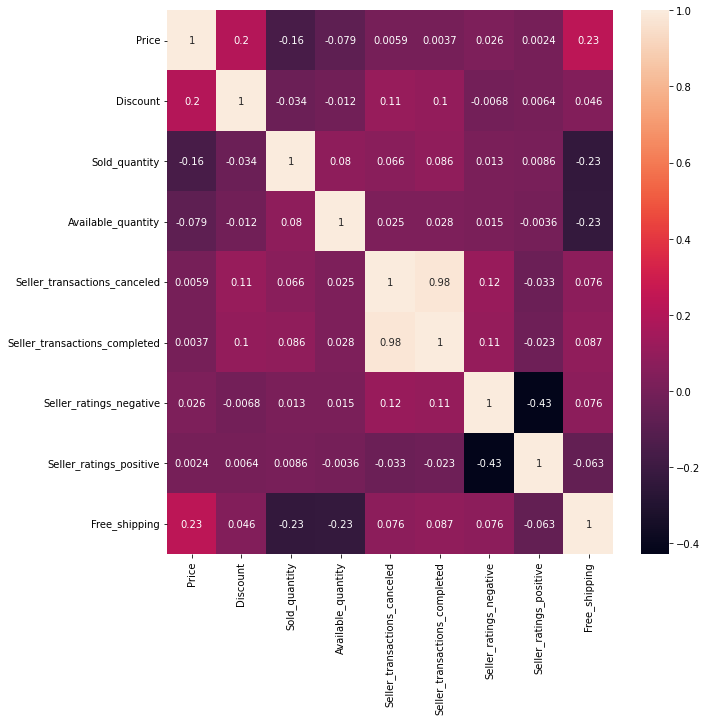

#################################
## Otras metricas
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive
count,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,39287.124029,473.680952,208.578095,70.103810,3463.768571,59777.092381,0.022390,0.958057
std,62090.255269,3744.975411,656.263985,370.065103,4380.521057,72544.850962,0.034308,0.076471
min,100.000000,0.000000,0.000000,1.000000,0.000000,9.000000,0.000000,0.000000
25%,7018.962500,0.000000,5.000000,1.000000,445.000000,7288.000000,0.010000,0.950000
50%,15839.500000,0.000000,25.000000,4.000000,1585.000000,31291.000000,0.020000,0.970000
75%,42473.000000,0.000000,169.750000,40.000000,6483.000000,116876.000000,0.030000,0.980000
max,499999.000000,82080.000000,10859.000000,5000.000000,49612.000000,783691.000000,1.000000,1.000000


#############################
#############################
### Laptops y Accesorios
#############################
#############################
La cantidad de productos en los distintos descuentos son: 

  5%: 1984
  10%: 555
  15%: 96
  20%: 97
  25%: 186
  30%: 333

En totas hay 3251 para esta categoria. Lo que representa el 1.43% de productos.
El descuento promedio, asumiendo que cada descuento representa la cota superior de descuento, y tomando un punto medio como referencia
(para 5% seria de 2.5%), y calculando un promedio total en base a eso, el resultado es: 7.80%. 

#################################
## Los 10 productos mas vendidos
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Condition,Marca,Modelo,Seller_level,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive,Free_shipping
Index46,2999.00,0,5000,250,new,real cover,estampados,5_green,308,7611,0.00,1.00,False
Index48,1899.05,100,5000,250,new,real cover,estampados,5_green,308,7611,0.00,1.00,False
Index37,1299.00,1201,5000,500,new,suono,universal120wts,5_green,7542,106480,0.02,0.96,False
Index21,1299.00,2201,5000,500,new,libercam,rnot-01 / cun-12,5_green,49612,783691,0.05,0.93,False
Index45,759.00,0,5000,150,new,flowerpot.3d,stand laptop,5_green,401,8821,0.03,0.94,False
Index67,1930.00,0,5000,100,new,woox,woox,5_green,137,5176,0.01,0.98,False
Index273,799.00,0,5000,1,new,yosai technology,dp a hdmi,5_green,755,12636,0.01,0.99,False
Index25,134999.00,0,678,9486,new,dell,3505,5_green,7238,116876,0.04,0.94,True
Index1,62999.00,27000,636,76,new,hp,15-dw1080la,5_green,1619,33742,0.03,0.94,True
Index294,2966.50,524,500,1,new,devotoelectronics,hub 6-1,5_green,954,16739,0.00,0.99,False


  Reputacion promedio de los vendedores: 5.0
  Calificación promedio de los vendedores: 0.97
  El porcentaje  de las transacciones completadas por los vendedores: 95.13%
  El porcentaje  de productos nuevos: 100.0%
  El porcentaje  de productos con envío gratis: 20.0% 

Matrix de correlacion de las variables no nominales


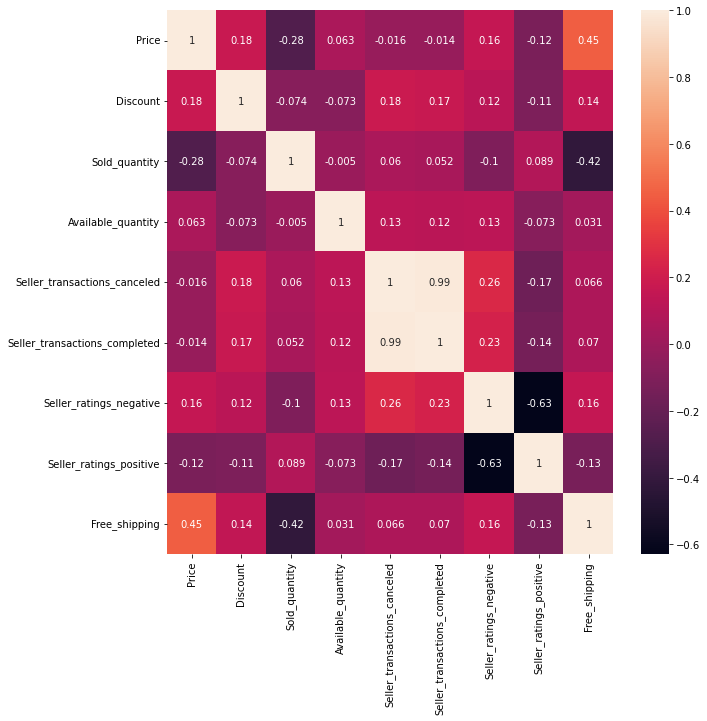

#################################
## Otras metricas
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive
count,1049.000000,1049.000000,1049.000000,1049.000000,1049.000000,1049.000000,1049.000000,1049.000000
mean,96790.118389,4678.954242,146.617731,623.937083,3509.594852,57527.571973,0.025453,0.956149
std,92605.891827,14072.284683,434.247062,2313.979920,6242.615204,106296.438865,0.021947,0.040927
min,229.000000,0.000000,0.000000,1.000000,2.000000,24.000000,0.000000,0.000000
25%,7990.000000,0.000000,5.000000,1.000000,335.000000,5725.000000,0.010000,0.940000
50%,85999.000000,0.000000,25.000000,1.000000,1310.000000,21279.000000,0.020000,0.960000
75%,143995.500000,100.000000,150.000000,50.000000,3903.000000,60827.000000,0.040000,0.970000
max,957399.000000,105000.000000,5000.000000,50000.000000,49612.000000,783691.000000,0.430000,1.000000


#############################
#############################
### Monitores y Accesorios
#############################
#############################
La cantidad de productos en los distintos descuentos son: 

  5%: 110
  10%: 20
  15%: 13
  20%: 55
  30%: 9

En totas hay 207 para esta categoria. Lo que representa el 1.57% de productos.
El descuento promedio, asumiendo que cada descuento representa la cota superior de descuento, y tomando un punto medio como referencia
(para 5% seria de 2.5%), y calculando un promedio total en base a eso, el resultado es: 8.57%. 

#################################
## Los 10 productos mas vendidos
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Condition,Marca,Modelo,Seller_level,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive,Free_shipping
Index1,33999.0,16001,3769,601,new,samsung,c24f390fh,5_green,41709,768918,0.05,0.93,True
Index3,35499.0,0,3424,558,new,samsung,f22t35,5_green,41709,768918,0.05,0.93,True
Index0,26999.0,0,2002,148,new,iqual,iq24h,5_green,7273,119167,0.03,0.95,True
Index4,8399.0,0,1815,31,new,sarasanto,ss-1032m,5_green,1751,38440,0.01,0.98,True
Index6,22499.0,0,1598,35,new,philips,193v5lsb2,5_green,41709,768918,0.05,0.93,True
Index7,41999.0,8001,1276,180,new,samsung,c27f390fh,5_green,41709,768918,0.05,0.93,True
Index14,52999.0,0,736,6,new,samsung,c24rg5,5_green,41709,768918,0.05,0.93,True
Index98,38999.0,0,500,1,new,samsung,f24t35,5_green,41709,768918,0.05,0.93,True
Index728,34499.0,0,500,1,new,samsung,c24f390fh,5_green,24075,349432,0.05,0.92,True
Index66,2749.0,0,500,200,new,mite,soporte monitor,5_green,338,9763,0.01,0.96,False


  Reputacion promedio de los vendedores: 5.0
  Calificación promedio de los vendedores: 0.94
  El porcentaje  de las transacciones completadas por los vendedores: 94.92%
  El porcentaje  de productos nuevos: 100.0%
  El porcentaje  de productos con envío gratis: 90.0% 

Matrix de correlacion de las variables no nominales


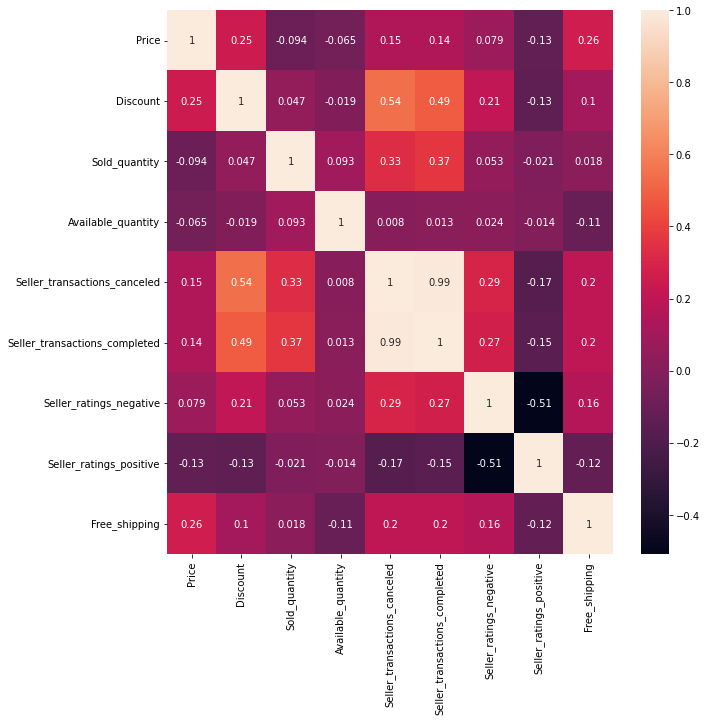

#################################
## Otras metricas
################################# 



,Price,Discount,Sold_quantity,Available_quantity,Seller_transactions_canceled,Seller_transactions_completed,Seller_ratings_negative,Seller_ratings_positive
count,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000,1044.000000
mean,51446.335479,1549.928161,51.660920,43.309387,4420.005747,71499.547893,0.024080,0.957117
std,58286.758665,6453.716451,207.576173,317.063672,7950.504579,131618.706983,0.026146,0.054034
min,449.000000,0.000000,0.000000,1.000000,0.000000,10.000000,0.000000,0.000000
25%,17050.000000,0.000000,2.000000,1.000000,185.500000,2515.000000,0.010000,0.947500
50%,38999.000000,0.000000,5.000000,1.000000,1260.000000,19795.000000,0.020000,0.970000
75%,67776.750000,0.000000,25.000000,1.000000,3903.000000,70806.000000,0.030000,0.980000
max,875000.000000,75500.000000,3769.000000,5000.000000,41709.000000,768918.000000,0.410000,1.000000


In [71]:
#Show metrics
codes = ['MLA1002','MLA1055','MLA430637','MLA454379','MLA400950','MLA430598','MLA3794','MLA430687','MLA1656']

for code in codes:
  #Vemos  metricas sobre los descuentos
  discount(code)
  df = gen_dataset(code)
  #vemos metricas de los 10 productos mas vendidos
  top_x_product(df, 10)
  #Vemos la relacion entre distintas variables
  print("Matrix de correlacion de las variables no nominales")
  corr_matrix(df)
  #Otras metricas
  other_metrics(df)

#Analisis

Se decidió analizar publicaciones dentro de la categoría ‘Tecnologia’. Una de las primeras cosas que saltan a simple vista es la baja proporción de productos en descuentos. De las 9 categorías analizadas se sacó un promedio, dando 1.7% de productos en descuento.
También se vio que el descuento promedio entre todas las categorías ronda el 7.4%.
Se observa también, que los productos más vendidos son aquellos que poseen vendedores de alta reputación, un dato que es coherente ya que es una métrica que normalmente se utiliza a la hora de comprar.
Otra métrica interesante es la relación que hay entre Sold_quantity y Seller_transactions_completed. En la matriz de correlación se puede ver que para la mayoria de las categorías esta variable es la que más se relaciona con Sold_quantity, lo cual es coherente ya que nuevamente, es un dato que normalmente es utilizado por los clientes.
También se puede mencionar que parece raro que la variable de descuento se relaciona muy poco con Sold_quantity, pero hay que recalcar que el porcentaje de productos con descuento es muy bajo, por lo que no hay información suficiente como para saber qué tanto afecta esta variable a Sold_quantity.

Algo que se destaca de los datos obtenidos con buscador de productos, con el cual se formó el dataset, es que posee demasiadas variables nominales, lo que seguramente dificulte el entrenamiento de un regresor lineal. Adicionalmente, pocas variables tienen un alto índice de relación con Sold_quantity, qué es la variable a predecir, lo cual esto también dificultará la predicción de dicha variable. Lo más probable es que se tenga que combinar diferentes tipos de filtros para buscar información específica y formar un dataset en una categoría en particular. También se podrían usar embeddings para trabajar con estas variables nominales y es un área que se puede explorar.


#Models

In [10]:
####################
##    Models      ##
####################

def perceptron( input_shape: int, optimizer='adam'):
  model = keras.Sequential([
    layers.Dense(1, activation=None, input_shape=(input_shape,))
  ])

  model.compile(loss='mse',
                optimizer=optimizer)
  
  return model


def regresion_net( input_shape: int, optimizer='adam'):
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_shape,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer=optimizer)
  return model

Armar un dataset para muchas categorías carece de sentido en muchos aspectos, ya que los productos tendrán diferentes características. Si bien se podría tratar de hacer, armar un dataset que tenga sentido podría llevar más tiempo del que dispongo. Lo más óptimo es centrarse en una categoría en concreto y explotar las características de la misma.
En mi caso me centré en celulares.

In [24]:
def gen_smartphone_dataset() -> PANDAS_TYPE:
  jsonSTR = {}
  url = 'https://api.mercadolibre.com/sites/MLA/search?category=MLA1055'
  complete_df = pd.DataFrame()

  #Flistramos por RAM
  for ram_id in ['(*-2GB]','[3GB-3GB]','[4GB-4GB]','[5GB-5GB]','[6GB-6GB]','[8GB-*)']:
    offset = 0
    #response_api = requests.get(f"{url}&RAM={ram_id}&offset={offset}")
    while True:
      response_api = requests.get(f"{url}&RAM={ram_id}&offset={offset}")
      #jsonSTR = gen_json(response_api.json()['results'], jsonSTR, offset)
      for j in range(len(response_api.json()['results'])):
        other_information = requests.get(f"https://api.mercadolibre.com/items/{response_api.json()['results'][j]['id']}").json()
        product = response_api.json()['results'][j]
        #seller_r = product["seller"]["seller_reputation"]
        seller_r = product["seller"].get('seller_reputation', {})
        attributes = {atr["name"]:atr["value_name"] for atr in other_information.get('attributes', [])}

        jsonSTR["Index{}".format(offset+j)] = {
                "Price": product["price"],
                "Discount": int(product["original_price"]) - int(product["price"]) if product["original_price"] else 0,
                "Sold_quantity": product["sold_quantity"],
                "Available_quantity": product["available_quantity"],
                "Condition": product["condition"],
                "Marca": attributes.get('Marca', "0"),
                "Modelo": attributes.get('Modelo', "0"),
                "Capacidad de la batería": attributes.get("Capacidad de la batería", "0"),
                "Color": attributes.get("Color", ""),
                "Relación de aspecto de la pantalla": attributes.get("Relación de aspecto de la pantalla", "0"),
                "Píxeles por pulgada de la pantalla":attributes.get("Píxeles por pulgada de la pantalla", "0"),
                "Frecuencia de actualización de la pantalla": attributes.setdefault("Frecuencia de actualización de la pantalla", "60"),
                "Resolución de la pantalla": attributes.get("Resolución de la pantalla", "0"),
                "Tamaño de la pantalla": attributes.get("Tamaño de la pantalla", "0"),
                "Tecnología de la pantalla": attributes.get("Tecnología de la pantalla", "0"),
                "Cantidad de cámaras frontales": attributes.get("Cantidad de cámaras frontales", "0"),
                "Modelo de GPU": attributes.get("Modelo de GPU", "0"),
                "Velocidad del GPU": attributes.get("Velocidad del GPU", "0"),
                "Memoria interna": attributes.get("Memoria interna", "0"),
                "Resolución de la cámara frontal principal": attributes.get("Resolución de la cámara frontal principal", "0"),
                "Resolución de la cámara trasera principal": attributes.get("Resolución de la cámara trasera principal", "0"),
                "Capacidad máxima de la tarjeta de memoria": attributes.get("Capacidad máxima de la tarjeta de memoria", "0"),
                "Cantidad de núcleos del procesador": attributes.get("Cantidad de núcleos del procesador", "0"),
                "Modelo del procesador": attributes.get("Modelo del procesador", "0"),
                "Velocidad del procesador": attributes.get("Velocidad del procesador", "0"),
                "RAM": attributes.get("Memoria RAM", "0"),
                "Cantidad de cámaras traseras":attributes.get("Cantidad de cámaras traseras", "0"),
                "Peso": attributes.get("Peso", "0"),
                "Ancho": attributes.get("Ancho", "0"),
                "Altura": attributes.get("Altura", "0"),
                "Con carga rápida": attributes.get("Con carga rápida", "0"),
                "Seller_level": seller_r.get("level_id", '0'),
                "Seller_transactions_canceled": seller_r.get("transactions", {}).get("canceled", '0'),
                "Seller_transactions_completed": seller_r.get("transactions", {}).get("completed", '0'),
                "Seller_ratings_negative": seller_r.get("transactions", {}).get("ratings", {}).get('negative', '0'),
                "Seller_ratings_positive": seller_r.get("transactions", {}).get("ratings", {}).get('positive', '0'),
                "Free_shipping": product["shipping"]["free_shipping"],
            }

      offset +=50
      if not((offset<1000) and (offset < response_api.json()['paging']['total'])):
        break

    df = pd.DataFrame.from_dict(jsonSTR, orient ='index')
    complete_df = pd.concat([complete_df,df])

  return complete_df

def formating_dataset(df2: PANDAS_TYPE) -> PANDAS_TYPE:
  cols = ['']
  number_cols = ['Capacidad de la batería','Píxeles por pulgada de la pantalla','Frecuencia de actualización de la pantalla',\
              'Tamaño de la pantalla','Cantidad de cámaras frontales','Velocidad del GPU',\
              'Resolución de la cámara frontal principal','Resolución de la cámara trasera principal',\
              'Cantidad de núcleos del procesador','Velocidad del procesador',\
              'RAM','Cantidad de cámaras traseras','Peso','Ancho','Altura']
  for col in number_cols:
    for i in range(len(df2[col])):
      df2[col][i] = df2[col][i].replace(df2[col][i], df2[col][i].split(" ")[0])
    
    df2 = df2.astype({col: float})

  col = 'Color'
  for i in range(len(df2[col])):
    df2[col][i] = df2[col][i].replace(df2[col][i], df2[col][i].split(" ")[0])

  col = 'Resolución de la pantalla'
  for i in range(len(df2[col])):
    numbers_in_str = re.findall('\d+', df2[col][i])
    resolution = float(numbers_in_str[0]) * float(numbers_in_str[1])
    df2[col][i] = df2[col][i].replace(df2[col][i], str(resolution))
  df2 = df2.astype({col: float})

  for col in ['Memoria interna', 'Capacidad máxima de la tarjeta de memoria']:
    for i in range(len(df2[col])):
      unit = df2[col][i].split(" ")[1]
      value = float((df2[col][i].split(" ")[0]))
      if unit.lower()=='gb':
        value = value * 1024
      elif unit.lower()=='tb':
        value = value * (1024**2)
      df2[col][i] = df2[col][i].replace(df2[col][i], str(value))
    df2 = df2.astype({col: float})

  return df2

def plot_training(history: keras.callbacks.History) -> None:
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

##Creamos y formateamos el dataset

In [31]:
#Creamos el dataset pegandole a la api
df = gen_smartphone_dataset()
#Limpiamos rows con valores en Null
df = df.replace('0', None).dropna()
#Hacemos un formateo de los datos
df = formating_dataset(df)
#Remplazamos los valores nominales a numericos
string_colums = ["Condition","Marca","Modelo",'Color','Relación de aspecto de la pantalla',"Seller_level","Free_shipping",\
                 'Tecnología de la pantalla','Modelo de GPU','Modelo del procesador','Con carga rápida']
df = conver_to_numeric(df,string_colums)
#Desordenamos el dataset
df_shuffled = df.sample(frac=1).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to b

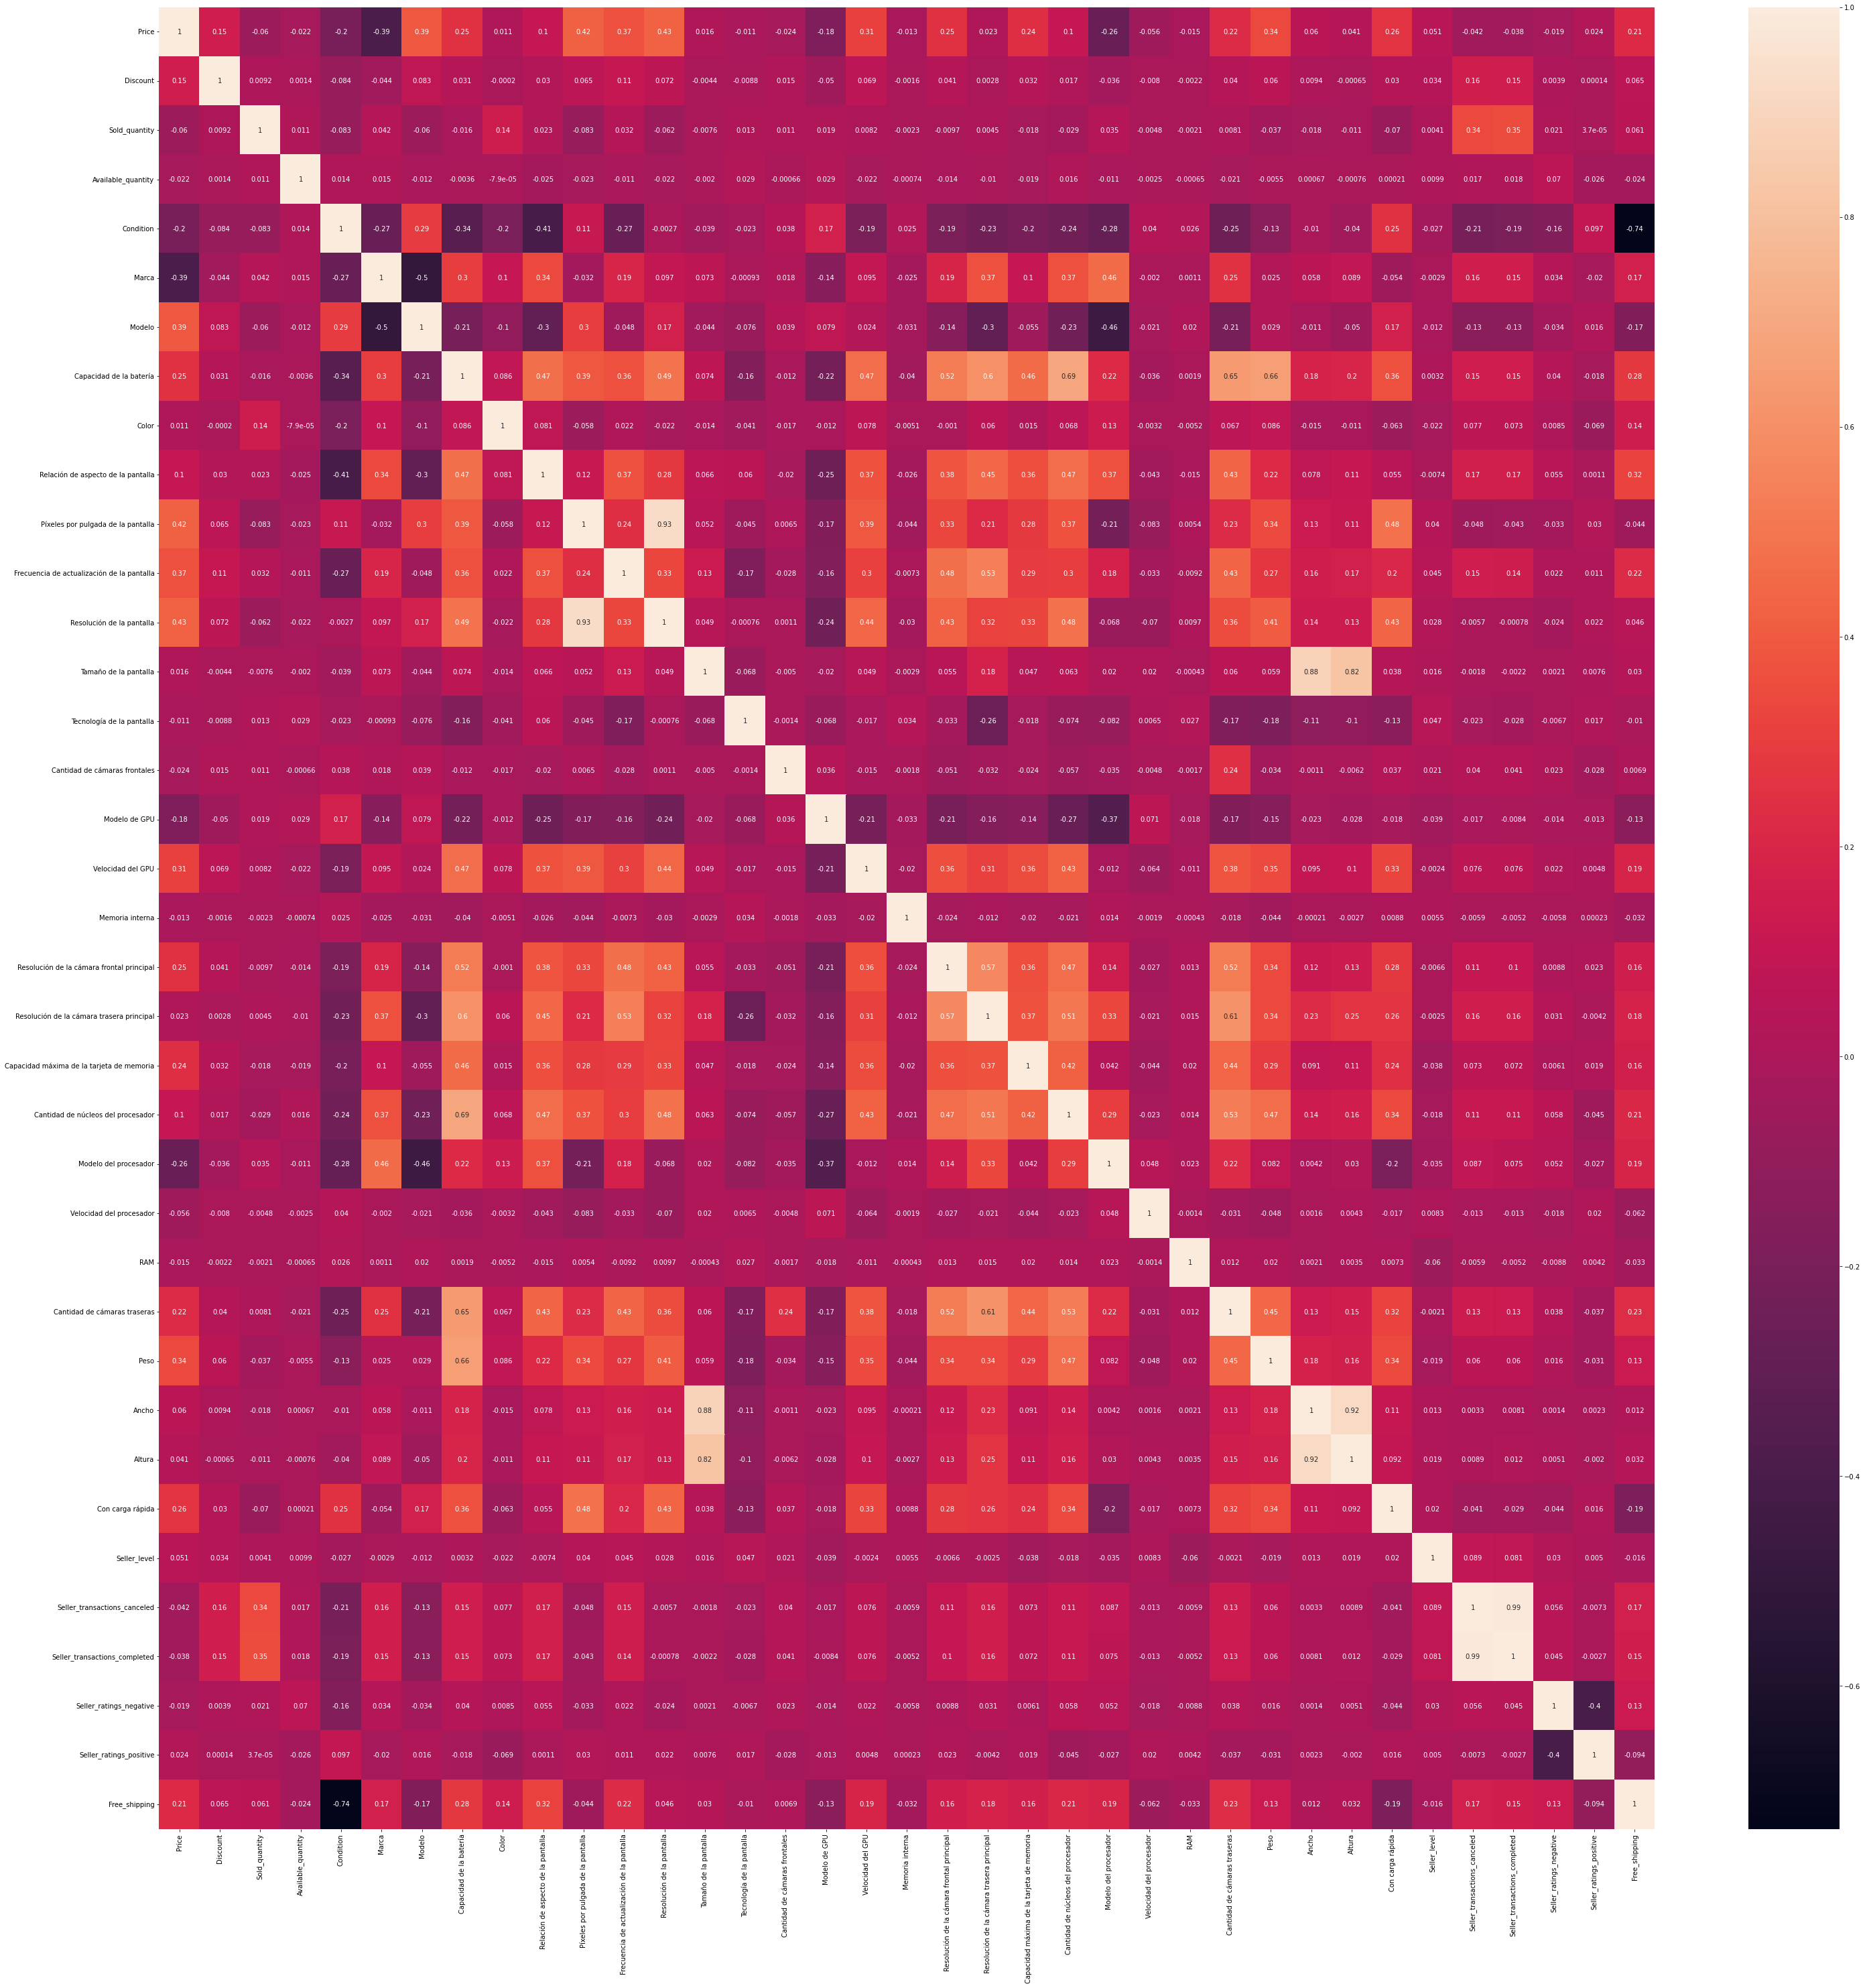

In [239]:
corr_df = df.corr(method='pearson')
plt.figure(figsize=(50, 50))
sns.heatmap(corr_df, annot=True)
plt.show()

##Partimos el dataset en training y testing datasets

In [40]:
y = df_shuffled['Sold_quantity']
x = df_shuffled.drop('Sold_quantity', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)
print(f"x_train: {x_train.shape} y_train: {y_train.shape}")
print(f"x_test: {x_test.shape} y_train: {y_test.shape}")
#normalizamos con la media y desviación estándar 
x_train = nor_std(x_train)
x_test = nor_std(x_test)

x_train: (2403, 36) y_train: (2403,)
x_test: (601, 36) y_train: (601,)


##Probando un modelo lineal básico. Perceptrón

Se han truncado las últimas 5000 líneas del flujo de salida.
76/76 [==============================] - 0s 2ms/step - loss: 26515.7754 - val_loss: 19420.3203
Epoch 502/3000
76/76 [==============================] - 0s 2ms/step - loss: 26512.9336 - val_loss: 19418.3320
Epoch 503/3000
76/76 [==============================] - 0s 2ms/step - loss: 26510.2344 - val_loss: 19416.3730
Epoch 504/3000
76/76 [==============================] - 0s 2ms/step - loss: 26507.3848 - val_loss: 19414.9043
Epoch 505/3000
76/76 [==============================] - 0s 2ms/step - loss: 26504.5664 - val_loss: 19413.2402
Epoch 506/3000
76/76 [==============================] - 0s 2ms/step - loss: 26502.0703 - val_loss: 19411.2090
Epoch 507/3000
76/76 [==============================] - 0s 2ms/step - loss: 26499.1523 - val_loss: 19409.7773
Epoch 508/3000
76/76 [==============================] - 0s 2ms/step - loss: 26496.5801 - val_loss: 19408.1543
Epoch 509/3000
76/76 [==============================] - 0s 2ms/step - loss

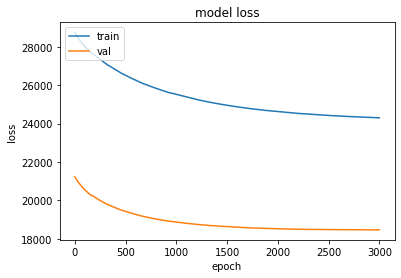

In [44]:
input_shape = x_train.shape[1]
modelo = perceptron(input_shape, 'adam')
history = modelo.fit(x_train,y_train,epochs=3000,batch_size=32, validation_data=(x_test,y_test))
plot_training(history)

Como se puede ver, el perceptrón no tiene la suficiente capacidad para ajustar la relación que hay entre los datos, por lo que se puede concluir que los datos siguen una relación no lineal. Será necesario entonces probar un modelo con capacidad de representación no lineal, tales como lo son la redes neuronales. 
Otra curiosidad es que por alguna razón la evaluación da un error mucho más bajo que el training, algo que hace sonar muchas alarmas sobre si el modelo o los datos están creados correctamente. 


##Probamos un modelo no lineal. Red fully connected

Epoch 1/200
38/38 [==============================] - 1s 7ms/step - loss: 28613.5723 - val_loss: 21030.2227
Epoch 2/200
38/38 [==============================] - 0s 4ms/step - loss: 28358.6211 - val_loss: 20711.2559
Epoch 3/200
38/38 [==============================] - 0s 3ms/step - loss: 27966.0957 - val_loss: 20257.6152
Epoch 4/200
38/38 [==============================] - 0s 3ms/step - loss: 27443.0234 - val_loss: 19825.5332
Epoch 5/200
38/38 [==============================] - 0s 3ms/step - loss: 26856.0684 - val_loss: 19415.9414
Epoch 6/200
38/38 [==============================] - 0s 3ms/step - loss: 26091.3242 - val_loss: 18950.9043
Epoch 7/200
38/38 [==============================] - 0s 3ms/step - loss: 25341.9785 - val_loss: 18588.2227
Epoch 8/200
38/38 [==============================] - 0s 3ms/step - loss: 24447.6504 - val_loss: 18337.8809
Epoch 9/200
38/38 [==============================] - 0s 3ms/step - loss: 23918.9805 - val_loss: 18160.2168
Epoch 10/200
38/38 [=================

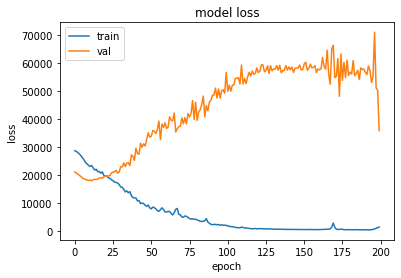

In [48]:
modelo = regresion_net(x_train.shape[1], 'adam')

history = modelo.fit(x_train,y_train,epochs=200,batch_size=64, validation_data=(x_test,y_test))
plot_training(history)

Para este caso, se puede ver que el modelo logra captar la relación de los datos, pero hay un claro ejemplo de overfitting, por lo que el modelo es demasiado complejo para este problema.
Probamos una red más sencilla y vemos como se comporta.

In [58]:

def regresion_net_2( input_shape: int, optimizer='adam'):
  model = keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=(input_shape,)),
    layers.Dense(4, activation='relu'),
    layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer=optimizer)
  return model

Epoch 1/400
38/38 [==============================] - 1s 10ms/step - loss: 28704.4336 - val_loss: 21171.9766
Epoch 2/400
38/38 [==============================] - 0s 4ms/step - loss: 28688.5293 - val_loss: 21154.8926
Epoch 3/400
38/38 [==============================] - 0s 5ms/step - loss: 28673.9648 - val_loss: 21130.4434
Epoch 4/400
38/38 [==============================] - 0s 6ms/step - loss: 28655.8633 - val_loss: 21097.9531
Epoch 5/400
38/38 [==============================] - 0s 3ms/step - loss: 28631.1602 - val_loss: 21055.2969
Epoch 6/400
38/38 [==============================] - 0s 3ms/step - loss: 28594.7305 - val_loss: 20998.7363
Epoch 7/400
38/38 [==============================] - 0s 3ms/step - loss: 28549.9355 - val_loss: 20950.5430
Epoch 8/400
38/38 [==============================] - 0s 4ms/step - loss: 28499.4551 - val_loss: 20890.1387
Epoch 9/400
38/38 [==============================] - 0s 10ms/step - loss: 28440.0723 - val_loss: 20828.8262
Epoch 10/400
38/38 [===============

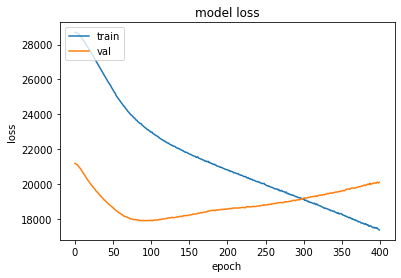

In [59]:
modelo = regresion_net_2(x_train.shape[1], 'adam')

history = modelo.fit(x_train,y_train,epochs=400,batch_size=64, validation_data=(x_test,y_test))
plot_training(history)

Podemos ver que para un modelo más simple, la convergencia es más tardía pero caemos nuevamente en el overfitting

In [60]:
def regresion_net_3( input_shape: int, optimizer='adam'):
  model = keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=(input_shape,)),
    layers.Dense(1)
  ])

  model.compile(loss='mse',
                optimizer=optimizer)
  return model

Epoch 1/400
38/38 [==============================] - 1s 10ms/step - loss: 28715.0195 - val_loss: 21179.0703
Epoch 2/400
38/38 [==============================] - 0s 4ms/step - loss: 28697.1094 - val_loss: 21161.8359
Epoch 3/400
38/38 [==============================] - 0s 5ms/step - loss: 28677.1074 - val_loss: 21139.3184
Epoch 4/400
38/38 [==============================] - 0s 4ms/step - loss: 28651.5391 - val_loss: 21111.4512
Epoch 5/400
38/38 [==============================] - 0s 4ms/step - loss: 28624.4492 - val_loss: 21078.6348
Epoch 6/400
38/38 [==============================] - 0s 6ms/step - loss: 28598.8418 - val_loss: 21039.7871
Epoch 7/400
38/38 [==============================] - 0s 8ms/step - loss: 28569.0020 - val_loss: 20998.2129
Epoch 8/400
38/38 [==============================] - 0s 7ms/step - loss: 28533.8789 - val_loss: 20963.1445
Epoch 9/400
38/38 [==============================] - 0s 5ms/step - loss: 28504.2754 - val_loss: 20915.2246
Epoch 10/400
38/38 [================

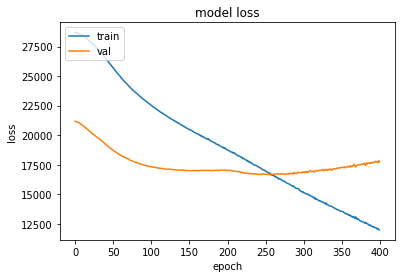

In [61]:
modelo = regresion_net_2(x_train.shape[1], 'adam')

history = modelo.fit(x_train,y_train,epochs=400,batch_size=64, validation_data=(x_test,y_test))
plot_training(history)

##Conclusión  

La conclusión que se saca de esto es coherente con lo que pensaba al inicio. Predecir las ventas que tendrá un producto es una tarea muy compleja, para la cual ni siquiera existen reglas que permitan a priori saberlas, ya que la venta de un producto depende de demasiados factores sobre los que no se tienen control. Por ejemplo, si tenemos 2 productos, a y b, exactamente iguales en cuanto a características, iguales en cuanto a reputación de vendedor, etc, lo más probable es que el producto que tenga más ventas en el presente será el que tenga más ventas en el futuro, debido a que las personas suelen mirar la cantidad de ventas. Asimismo, si por alguna razón una persona influyente hiciera propaganda de manera directa o indirecta sobre un producto x, lo natural es que este aumente sus ventas. 
Se concluye que es una variable complicada de trabajar sin hacer demasiadas asunciones.


##Pendiente 
Quedó como pendiente por falta de tiempo trabajar con embeddings, los cuales permitirían obtener información más rica de las variables nominales, las cuales eran bastantes, aunque se pudieron transformar varias de estas de manera manual. 

